In [1]:
import json

VQA_MODEL_TO_DISPLAYNAME = {
    'instructblipflant5xl': 'InstructBLIP',
    'blip2flant5xl': 'BLIP2',
}
vlm_name = 'blip2flant5xl'
vlm_displayname = VQA_MODEL_TO_DISPLAYNAME[vlm_name]

qid2calibrollouts = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/sherlock/calibeval_outputs/{vlm_name}_direct_vqa_noboxfill_newprompt_balanced-664examples.json'))
qids = list(qid2calibrollouts.keys())
print(f"Loaded {len(qids)} qids from {vlm_displayname}'s Sherlock rollouts")


Loaded 664 qids from BLIP2's Sherlock rollouts


In [2]:
import numpy as np

prob_type = 'yn_prob'   # 'first_token_prob', 'min_token_prob', 'mean_token_prob', 'exp_mean_token_logprobs', 'prod_probs'
predicted_answer_probs = []
predicted_answer_accs = []

for qid in qids:
    for rollout in qid2calibrollouts[qid]:
        if rollout['lave_score'] not in [0.0, 1.0]:
            continue
        acc = 1 if rollout['lave_score'] == 1.0 else 0
        if prob_type == 'exp_mean_token_logprobs':
            logprobs = rollout['answer_logprobs_dict']['answer_token_logprobs']
            prob = np.exp(np.mean(logprobs))
        elif prob_type == 'prod_token_probs':
            #logprobs = rollout['answer_logprobs_dict']['answer_token_logprobs']
            #token_probs = rollout['answer_logprobs_dict']['token_probs']
            #prob = np.prod(token_probs[:-1])
            prob = rollout['answer_logprobs_dict'][prob_type]
        else:
            prob = rollout['answer_logprobs_dict'][prob_type]
        predicted_answer_probs.append(prob)
        predicted_answer_accs.append(acc)
print(len(predicted_answer_accs))

664


In [3]:
bin_accs, bin_meanprobs, bin_sizes, bin_stdprobs = [], [], [], []
num_bins = 10
for i in range(num_bins):
    bin_lower = i*1.0/num_bins
    bin_upper = (i+1)*1.0/num_bins
    bin_idxs = [i for i in range(len(predicted_answer_accs)) if predicted_answer_probs[i] >= bin_lower and predicted_answer_probs[i] < bin_upper]
    print(f"Bin {bin_lower:.2f}-{bin_upper:.2f}: {len(bin_idxs)} instances")
    bin_individualaccs = [predicted_answer_accs[i] for i in bin_idxs]
    bin_individualprobs = [predicted_answer_probs[i] for i in bin_idxs]
    print(f"Bin accuracy: {np.mean(bin_individualaccs):.2%}")
    print(f"Mean predicted probability for bin: {np.mean(bin_individualprobs):.2%}")
    bin_accs.append(np.mean(bin_individualaccs))
    bin_meanprobs.append(np.mean(bin_individualprobs))
    bin_sizes.append(len(bin_idxs))
    bin_stdprobs.append(np.std(bin_individualprobs))

Bin 0.00-0.10: 257 instances
Bin accuracy: 76.65%
Mean predicted probability for bin: 5.64%
Bin 0.10-0.20: 207 instances
Bin accuracy: 46.38%
Mean predicted probability for bin: 14.09%
Bin 0.20-0.30: 78 instances
Bin accuracy: 34.62%
Mean predicted probability for bin: 23.72%
Bin 0.30-0.40: 15 instances
Bin accuracy: 73.33%
Mean predicted probability for bin: 35.60%
Bin 0.40-0.50: 31 instances
Bin accuracy: 87.10%
Mean predicted probability for bin: 45.56%
Bin 0.50-0.60: 32 instances
Bin accuracy: 100.00%
Mean predicted probability for bin: 55.31%
Bin 0.60-0.70: 19 instances
Bin accuracy: 94.74%
Mean predicted probability for bin: 64.84%
Bin 0.70-0.80: 13 instances
Bin accuracy: 92.31%
Mean predicted probability for bin: 74.13%
Bin 0.80-0.90: 12 instances
Bin accuracy: 100.00%
Mean predicted probability for bin: 84.54%
Bin 0.90-1.00: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%


/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
correct_probs, incorrect_probs = [], []
correct_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 1]
incorrect_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 0]

correct_probs = [predicted_answer_probs[i] for i in correct_idxs]
incorrect_probs = [predicted_answer_probs[i] for i in incorrect_idxs]
print(f"{len(correct_probs)} correct predictions, {len(incorrect_probs)} incorrect predictions")

432 correct predictions, 232 incorrect predictions


In [5]:
unweighted_calibration_error = np.mean(np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))
calibration_error = np.sum((np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))*np.array(bin_sizes))/len(qids)


from scipy.stats import pearsonr, skew
freqdistr_skew = skew(predicted_answer_probs)
#r = pearsonr(prob_true, prob_pred)
#print(r.statistic)

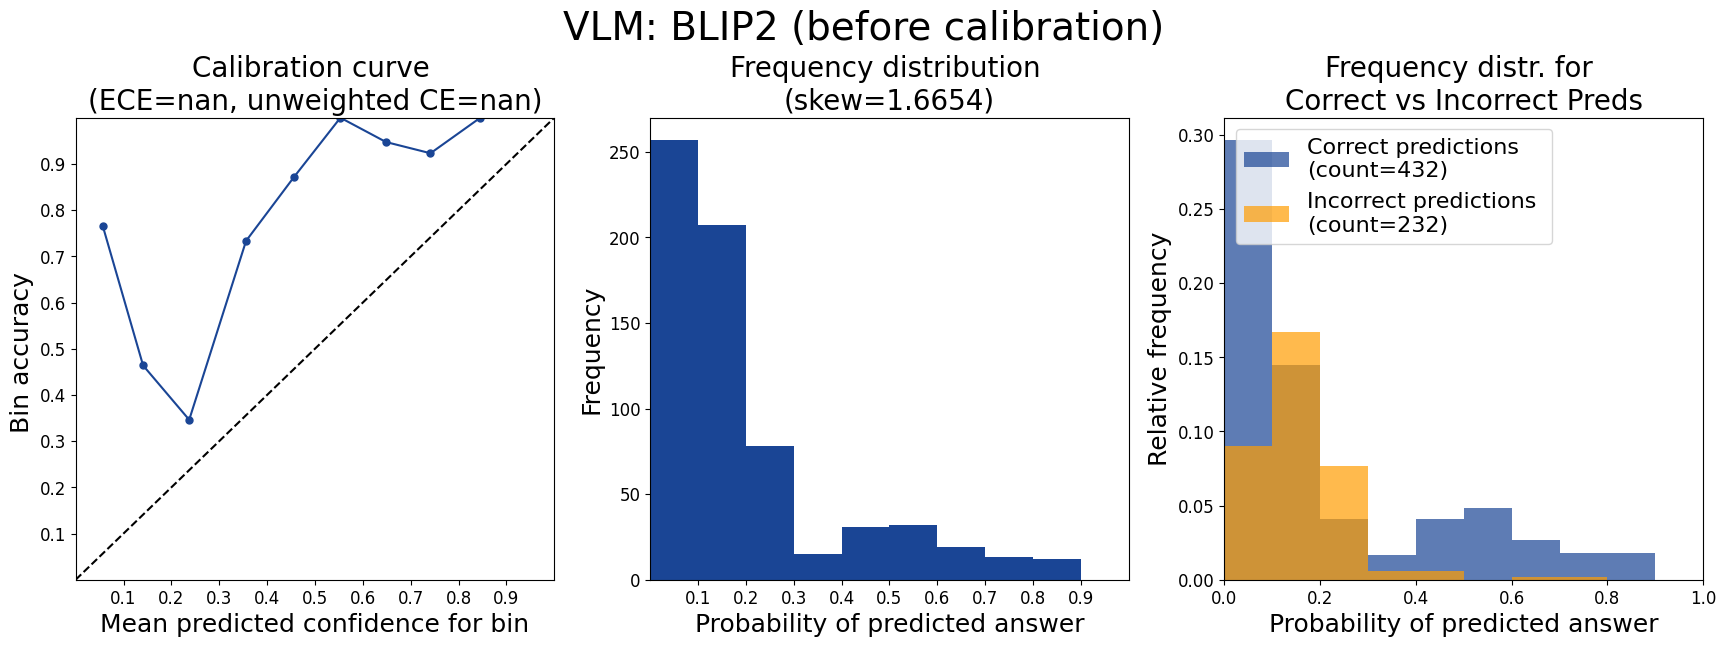

In [6]:
from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VLM: {vlm_displayname} (before calibration)\n\n', fontsize=28, y=1.06)
fig.set_size_inches(21, 6)
ax1.plot(bin_meanprobs, bin_accs, marker='.', markersize=10, color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve \n(ECE={calibration_error:.4f}, unweighted CE={unweighted_calibration_error:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)

freqhist_bins = np.linspace(0, 1, num_bins+1)
ax2.hist(
    predicted_answer_probs, 
    freqhist_bins, 
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(qids)
)
ax2.set_title(f'Frequency distribution \n(skew={freqdistr_skew:.4f})', fontsize=20)
ax2.set_xlabel('Probability of predicted answer', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])#, fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)


ax3.hist(
    correct_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#1a4595', 
    label='Correct predictions \n(count={})'.format(len(correct_probs)), 
    weights=np.ones_like(correct_probs) / len(qids))
ax3.hist(
    incorrect_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#ff9d02', 
    label='Incorrect predictions \n(count={})'.format(len(incorrect_probs)), 
    weights=np.ones_like(incorrect_probs) / len(qids))
ax3.set_title(f'Frequency distr. for \nCorrect vs Incorrect Preds', fontsize=20)
ax3.set_xlabel('Probability of predicted answer', fontsize=18)
ax3.set_ylabel('Relative frequency', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='upper left', fontsize=16)
ax3.set_xlim(0, 1)
plt.show()


## Selective prediction

In [7]:
from tqdm import tqdm

def calculate_abstention_metrics(qid2rollouts, threshold, error_cost=1):
    num_covered, total_risk, effective_reliability = 0, 0, 0
    qids = list(qid2rollouts.keys())
    abstained_qids = []
    for qid in qids:
        rollout = qid2rollouts[qid][0]
        acc = rollout['lave_score']
        conf = rollout['answer_logprobs_dict']['yn_prob']
        selected = True if conf >= threshold else False
        if selected:
            num_covered += 1
            total_risk += 1 - acc #if acc != 1 else 0
            effective_reliability += acc if acc > 0 else -error_cost
        else:
            abstained_qids.append(qid)
    coverage = num_covered/len(qids)
    risk = total_risk/num_covered if num_covered > 0 else 0
    effective_reliability = effective_reliability/len(qids)
    return coverage, risk, effective_reliability, abstained_qids

num_thresholds = 100
penalty = 1
thresholds = [i/num_thresholds for i in range(1, num_thresholds)]
coverages, risks, eff_reliabilities = [], [], []
for t in tqdm(thresholds):
    c, r, e, _ = calculate_abstention_metrics(qid2calibrollouts, t, penalty)
    coverages.append(c)
    risks.append(r)
    eff_reliabilities.append(e)
#for t, c, r in zip(thresholds, coverages, risks):
#    print(f"At confidence threshold {t}, coverage={c:.2%}, risk={r:.2%}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 4062.98it/s]


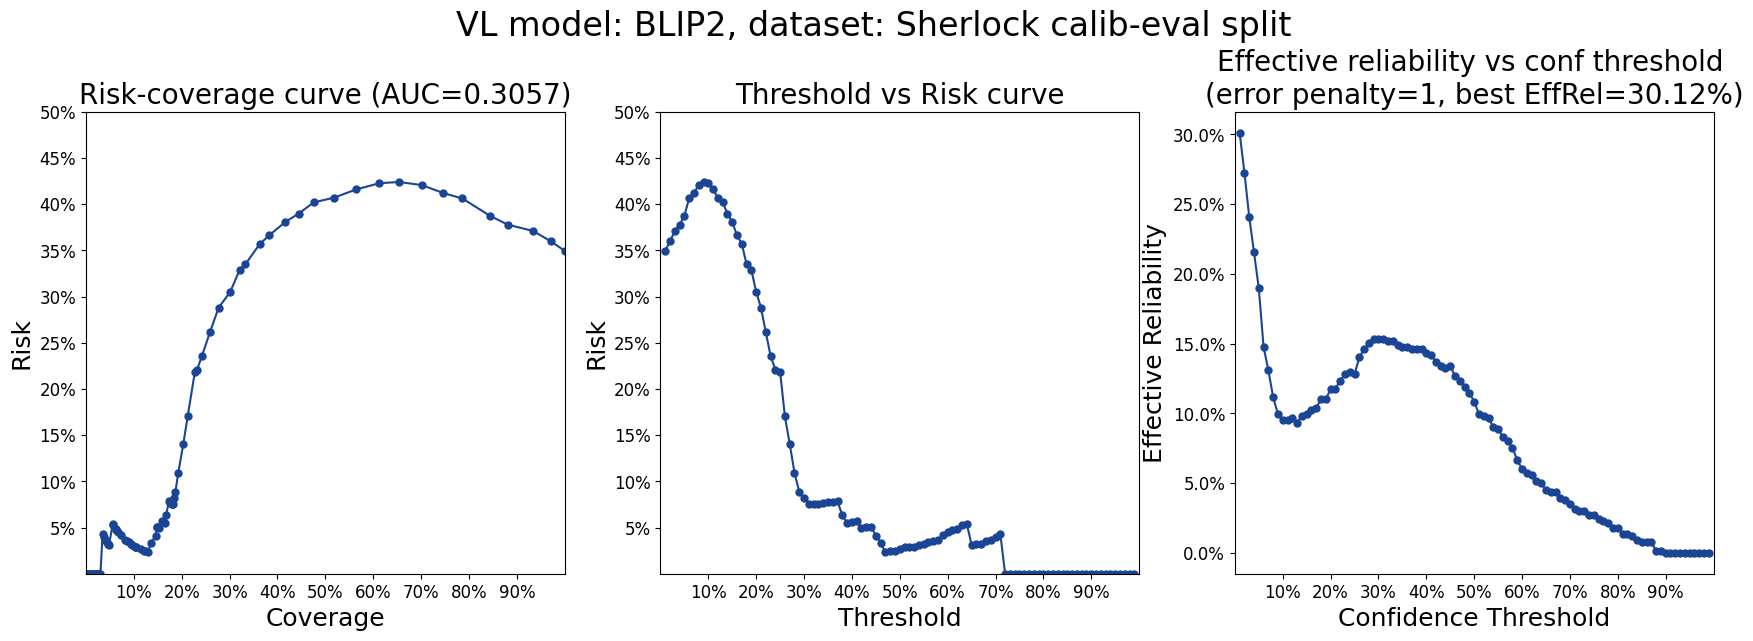

In [8]:
from sklearn import metrics
auc = metrics.auc(coverages, risks)

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VL model: {vlm_displayname}, dataset: Sherlock calib-eval split\n\n\n\n', fontsize=24, y=1.05)
fig.set_size_inches(21, 6)
ax1.plot(coverages, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Risk-coverage curve (AUC={auc:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Coverage', fontsize=18)
ax1.set_ylabel('Risk', fontsize=18)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2.plot(thresholds, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'Threshold vs Risk curve', fontsize=20)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax2.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.5)
ax2.set_xlabel('Threshold', fontsize=18)
ax2.set_ylabel('Risk', fontsize=18)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.plot(thresholds, eff_reliabilities, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax3.set_title(f'Effective reliability vs conf threshold \n(error penalty={penalty}, best EffRel={max(eff_reliabilities):.2%})', fontsize=20)
ax3.set_xticks(ticks=[i/10 for i in range(1, 10)])
#ax.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlim(0, 1)
#ax.set_ylim(0, 0.5)
ax3.set_xlabel('Confidence Threshold', fontsize=18)
ax3.set_ylabel('Effective Reliability', fontsize=18)
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

In [9]:
def coverage_at_risk(desired_risk):
    gamma = min([thresholds[i] for i in range(num_thresholds-1) if risks[i] < desired_risk])
    c, r, e, abstained_qids = calculate_abstention_metrics(qid2calibrollouts, gamma, penalty)
    return gamma, c

def risk_at_coverage(desired_coverage):
    gamma = max([thresholds[i] for i in range(num_thresholds-1) if coverages[i] >= desired_coverage])
    c, r, e, abstained_qids = calculate_abstention_metrics(qid2calibrollouts, gamma, penalty)
    return gamma, r

#desired_coverage = 0.6245
desired_risk = 0.1
gamma, new_coverage = coverage_at_risk(desired_risk)
#new_risk = risk_at_coverage(desired_coverage)
gamma, print(new_coverage)

0.18674698795180722


(0.29, None)

In [10]:
for i in range(num_thresholds-1):
    print(f"At threshold {thresholds[i]}, coverage={coverages[i]:.4f}, risk={risks[i]:.4f}")

At threshold 0.01, coverage=1.0000, risk=0.3494
At threshold 0.02, coverage=0.9714, risk=0.3597
At threshold 0.03, coverage=0.9337, risk=0.3710
At threshold 0.04, coverage=0.8810, risk=0.3778
At threshold 0.05, coverage=0.8434, risk=0.3875
At threshold 0.06, coverage=0.7861, risk=0.4061
At threshold 0.07, coverage=0.7455, risk=0.4121
At threshold 0.08, coverage=0.7018, risk=0.4206
At threshold 0.09, coverage=0.6536, risk=0.4240
At threshold 0.1, coverage=0.6130, risk=0.4226
At threshold 0.11, coverage=0.5648, risk=0.4160
At threshold 0.12, coverage=0.5181, risk=0.4070
At threshold 0.13, coverage=0.4759, risk=0.4019
At threshold 0.14, coverage=0.4443, risk=0.3898
At threshold 0.15, coverage=0.4157, risk=0.3804
At threshold 0.16, coverage=0.3825, risk=0.3661
At threshold 0.17, coverage=0.3630, risk=0.3568
At threshold 0.18, coverage=0.3328, risk=0.3348
At threshold 0.19, coverage=0.3208, risk=0.3286
At threshold 0.2, coverage=0.3012, risk=0.3050
At threshold 0.21, coverage=0.2771, risk=0

In [96]:
min([thresholds[i] for i in range(num_thresholds-1) if risks[i] < desired_risk])

0.29

## Calibration

In [97]:
#qid2trainrollouts = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/sherlock/calibtrain_outputs/{vlm_name}_direct_vqa-813examples.json'))
qid2trainrollouts = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/sherlock/calibtrain_outputs/{vlm_name}_direct_vqa_noboxfill_newprompt_balanced-658examples.json'))
train_qids = list(qid2trainrollouts.keys())
print(f"Loaded {len(train_qids)} qids from {vlm_displayname}'s Sherlock rollouts")


Loaded 658 qids from BLIP2's Sherlock rollouts


In [98]:
def turn_rollouts_into_XY(qid2rollouts):
    X, y = [], []
    for qid in qid2rollouts:
        for r in qid2rollouts[qid]:
            #if r['lave_score'] not in [0, 1]:
            #    continue
            X.append(r['answer_logprobs_dict']['yn_logits'])
            y.append(r['lave_score'])
    return np.array(X), np.array(y)

X_train, y_train = turn_rollouts_into_XY(qid2trainrollouts)
X_test, y_test = turn_rollouts_into_XY(qid2calibrollouts)

print("Number of training samples for calibrator model:", X_train.shape)
print("Number of test samples for calibrator model:", X_test.shape)

Number of training samples for calibrator model: (658, 2)
Number of test samples for calibrator model: (664, 2)


In [99]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=10000, solver='lbfgs')
lr_model.fit(X_train, y_train)

LogisticRegression(C=10000)

In [100]:
lr_model.get_params()

{'C': 10000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [101]:
y_test_calibrated_probs = lr_model.predict_proba(X_test)
predicted_answer_probs = [y[1] for y in y_test_calibrated_probs]
predicted_answer_accs = y_test.tolist()

In [102]:
bin_accs, bin_meanprobs, bin_sizes, bin_stdprobs = [], [], [], []
num_bins = 10
for i in range(num_bins):
    bin_lower = i*1.0/num_bins
    bin_upper = (i+1)*1.0/num_bins
    bin_idxs = [i for i in range(len(predicted_answer_accs)) if predicted_answer_probs[i] >= bin_lower and predicted_answer_probs[i] < bin_upper]
    print(f"Bin {bin_lower:.2f}-{bin_upper:.2f}: {len(bin_idxs)} instances")
    bin_individualaccs = [predicted_answer_accs[i] for i in bin_idxs]
    bin_individualprobs = [predicted_answer_probs[i] for i in bin_idxs]
    print(f"Bin accuracy: {np.mean(bin_individualaccs):.2%}")
    print(f"Mean predicted probability for bin: {np.mean(bin_individualprobs):.2%}")
    bin_accs.append(np.mean(bin_individualaccs))
    bin_meanprobs.append(np.mean(bin_individualprobs))
    bin_sizes.append(len(bin_idxs))
    bin_stdprobs.append(np.std(bin_individualprobs))

Bin 0.00-0.10: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%
Bin 0.10-0.20: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%
Bin 0.20-0.30: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%
Bin 0.30-0.40: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%
Bin 0.40-0.50: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%
Bin 0.50-0.60: 70 instances
Bin accuracy: 88.57%
Mean predicted probability for bin: 58.37%
Bin 0.60-0.70: 480 instances
Bin accuracy: 55.00%
Mean predicted probability for bin: 64.56%
Bin 0.70-0.80: 114 instances
Bin accuracy: 92.98%
Mean predicted probability for bin: 73.08%
Bin 0.80-0.90: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%
Bin 0.90-1.00: 0 instances
Bin accuracy: nan%
Mean predicted probability for bin: nan%


/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [103]:
correct_probs, incorrect_probs = [], []
correct_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 1]
incorrect_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 0]

correct_probs = [predicted_answer_probs[i] for i in correct_idxs]
incorrect_probs = [predicted_answer_probs[i] for i in incorrect_idxs]
print(f"{len(correct_probs)} correct predictions, {len(incorrect_probs)} incorrect predictions")

432 correct predictions, 232 incorrect predictions


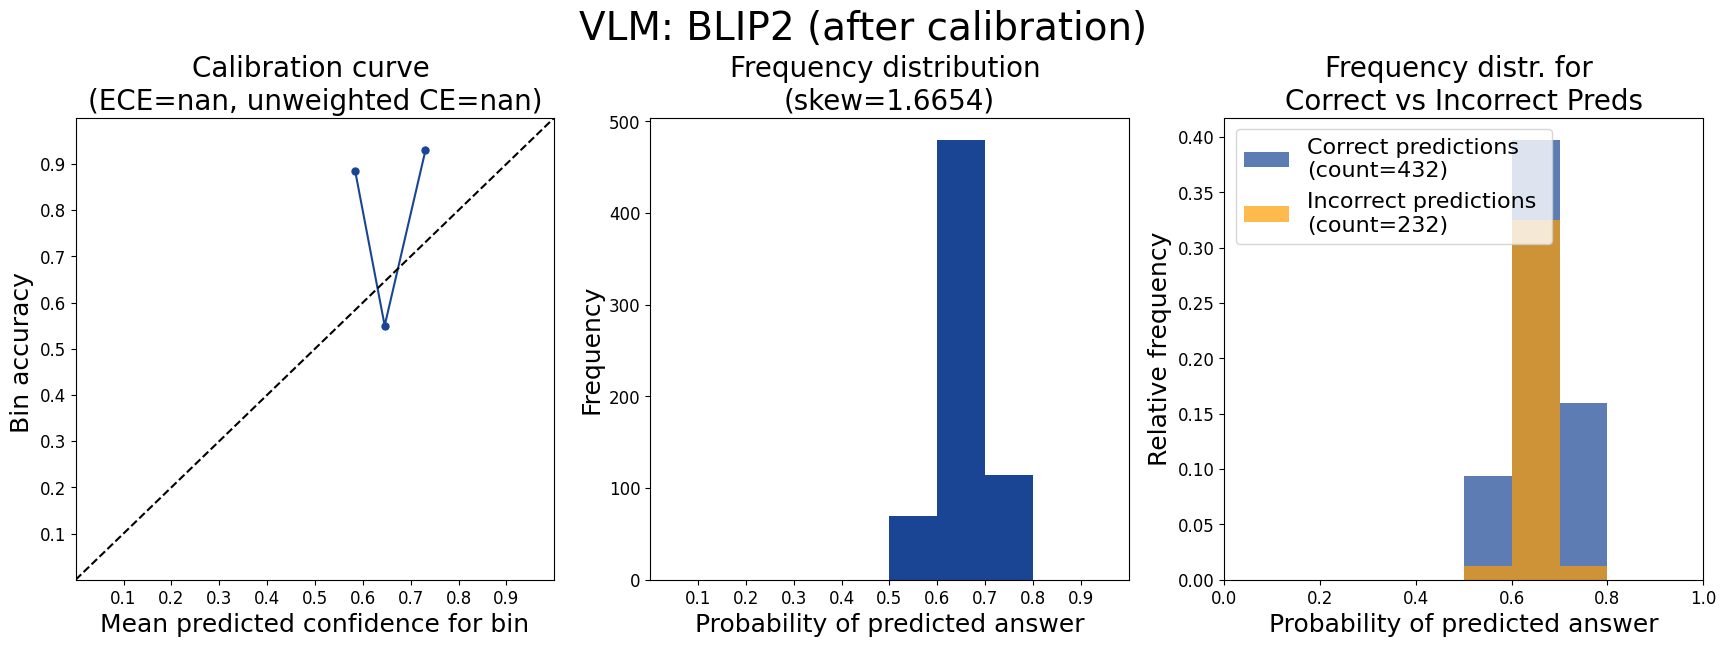

In [104]:
from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VLM: {vlm_displayname} (after calibration)\n\n', fontsize=28, y=1.06)
fig.set_size_inches(21, 6)
ax1.plot(bin_meanprobs, bin_accs, marker='.', markersize=10, color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve \n(ECE={calibration_error:.4f}, unweighted CE={unweighted_calibration_error:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)

freqhist_bins = np.linspace(0, 1, num_bins+1)
ax2.hist(
    predicted_answer_probs, 
    freqhist_bins, 
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(qids)
)
ax2.set_title(f'Frequency distribution \n(skew={freqdistr_skew:.4f})', fontsize=20)
ax2.set_xlabel('Probability of predicted answer', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])#, fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)


ax3.hist(
    correct_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#1a4595', 
    label='Correct predictions \n(count={})'.format(len(correct_probs)), 
    weights=np.ones_like(correct_probs) / len(qids))
ax3.hist(
    incorrect_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#ff9d02', 
    label='Incorrect predictions \n(count={})'.format(len(incorrect_probs)), 
    weights=np.ones_like(incorrect_probs) / len(qids))
ax3.set_title(f'Frequency distr. for \nCorrect vs Incorrect Preds', fontsize=20)
ax3.set_xlabel('Probability of predicted answer', fontsize=18)
ax3.set_ylabel('Relative frequency', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='upper left', fontsize=16)
ax3.set_xlim(0, 1)
plt.show()
